# Korean stock market EDA

## 0. Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# import streamlit as st

In [2]:
import FinanceDataReader as fdr
import quantstats as qs

In [3]:
## custom libs

from korquanttools.pricevolume.loader import KRXPriceDM
from korquanttools.pricevolume.utils import DateUtil
from korquanttools.pricevolume.config import PathConfig

In [19]:
from tqdm import tqdm

## 1. Import datasets

- Import price-volume data module from KRX using custom lib `korquanttools`
- Load/derive price, volume, market cap, dollar volume, etc from the dataset

In [4]:
# Global parameters

START = 20140101
END = 20221202

In [5]:
# Init data module
pricevolume = KRXPriceDM(START, END)
pricevolume.get_info()


        * DM name: KRX_pricevolume
        * DM description: Basic price-volume data imported from KRX website & NAVER finance. Has KOSPI, KOSDAQ, KONEX stocks.
        * birthday: 20211203
        * DM period: 19990101 ~ 
        * Available data: ['lv1', 'open', 'high', 'low', 'close', 'volume', 'dollarvolume', 'marketcap']
        


### 1-1. KRX raw data

In [6]:
# Download price-volume data from KRX.
# Also, build cache for faster access. (Both lv1 and lv2)

close_df = pricevolume.get_data("close")
close_df = close_df.astype(float)
close_df


ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,417500,419080,425420,438220,438580,440200,440790,446070,439410,442130
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,4440.0,438.0,111500.0,15500.0,73500.0,32600.0,21750.0,16850.0,182500.0,93300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,4540.0,440.0,114000.0,15400.0,71800.0,33400.0,21450.0,16850.0,180500.0,93000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,8770.0,574.0,10900.0,43450.0,64700.0,56000.0,25700.0,16200.0,56900.0,56400.0,...,10300.0,13500.0,8520.0,2000.0,2155.0,1980.0,1995.0,7420.0,NaN,NaN
2022-11-29,8840.0,594.0,10900.0,43700.0,65600.0,56000.0,26150.0,16200.0,57400.0,56700.0,...,10100.0,12600.0,8330.0,2000.0,2130.0,1975.0,1990.0,6900.0,NaN,NaN
2022-11-30,9020.0,592.0,11050.0,46000.0,66600.0,56800.0,26150.0,16200.0,58400.0,57100.0,...,10250.0,12600.0,8500.0,2000.0,2150.0,1975.0,1985.0,6360.0,NaN,NaN


In [7]:
volume_df = pricevolume.get_data('volume')
volume_df = volume_df.astype(float)

dollarvolume_df = pricevolume.get_data('dollarvolume')
dollarvolume_df = dollarvolume_df.astype(float)

marketcap_df = pricevolume.get_data('marketcap') # TODO: 현재 object로 불러와져 직접 astype(float) 해줘야 함. fix it. 
marketcap_df = marketcap_df.astype(float)

#### Caution: Data are unadjusted

- Let's take an example of Samsung Electronics (KOSPI:005930) that made a stock split

In [8]:
close_df.loc[:, '005930'] # 삼성전자. 
# 분할했었기 때문에 가격이 100만원 대에서 6만원 대로 변한다. 

trdDd
2014-01-01          NaN
2014-01-02    1309000.0
2014-01-03    1296000.0
2014-01-04          NaN
2014-01-05          NaN
                ...    
2022-11-28      60100.0
2022-11-29      60600.0
2022-11-30      62200.0
2022-12-01      62600.0
2022-12-02      60400.0
Name: 005930, Length: 3251, dtype: float64

In [9]:
volume_df.loc[:, '005930'] # 삼성전자
# volume 역시 unadjusted volume이다. 

trdDd
2014-01-01           NaN
2014-01-02      620500.0
2014-01-03      529932.0
2014-01-04           NaN
2014-01-05           NaN
                 ...    
2022-11-28     8589032.0
2022-11-29     7014160.0
2022-11-30    19768903.0
2022-12-01    16631445.0
2022-12-02    15331184.0
Name: 005930, Length: 3251, dtype: float64

### 1-2. Create derived datasets

In [10]:
lv1_df = pricevolume.get_data('lv1')
lv1_df

,ISU_SRT_CD,ISU_ABBRV,MKT_NM,SECT_TP_NM,TDD_CLSPRC,FLUC_TP_CD,CMPPREVDD_PRC,FLUC_RT,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,ACC_TRDVOL,ACC_TRDVAL,MKTCAP,LIST_SHRS,MKT_ID,trdDd,ISU_CD
1977,060310,3S,KOSDAQ,벤처기업부,4485,1,45,1.01,4550,4655,4475,402448,1832921960,183401821980,40892268,KSQ,2014-01-02,NaN
1978,013340,AJS,KOSDAQ,중견기업부,605,2,-15,-2.42,634,634,605,261969,161351265,23139709065,38247453,KSQ,2014-01-02,NaN
1979,068400,AJ렌터카,KOSPI,,12600,1,250,2.02,12450,12850,12350,153578,1933645400,279043380000,22146300,STK,2014-01-02,NaN
1980,006840,AK홀딩스,KOSPI,,41000,1,50,0.12,41000,41400,40150,17780,726244500,477550001000,11647561,STK,2014-01-02,NaN
1981,054620,AP시스템,KOSDAQ,우량기업부,9610,2,-250,-2.54,9990,10000,9610,707268,6924202690,220663503430,22961863,KSQ,2014-01-02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7541056,000547,흥국화재2우B,KOSPI,,21400,1,2100,10.88,19550,21700,19550,4526,94473600,3287040000,"153,600",STK,2022-12-01,KR7000542001
7541057,000545,흥국화재우,KOSPI,,6390,1,370,6.15,6110,6500,6100,7555,47721780,4907520000,"768,000",STK,2022-12-01,KR7000541003
7541058,003280,흥아해운,KOSPI,,1610,2,-15,-0.92,1625,1645,1600,358258,581878240,387084087390,"240,424,899",STK,2022-12-01,KR7003280005
7541059,037440,희림,KOSDAQ,우량기업부,11900,2,-100,-0.83,11950,12250,11750,1650283,19752583800,165677452500,"13,922,475",KSQ,2022-12-01,KR7037440005


In [11]:
lv1_df.columns

Index(['ISU_SRT_CD', 'ISU_ABBRV', 'MKT_NM', 'SECT_TP_NM', 'TDD_CLSPRC',
       'FLUC_TP_CD', 'CMPPREVDD_PRC', 'FLUC_RT', 'TDD_OPNPRC', 'TDD_HGPRC',
       'TDD_LWPRC', 'ACC_TRDVOL', 'ACC_TRDVAL', 'MKTCAP', 'LIST_SHRS',
       'MKT_ID', 'trdDd', 'ISU_CD'],
      dtype='object')

- Stock universe by market grouping (KOSPI, KOSDAQ, KONEX)

In [12]:
universe_df = close_df.notnull() # All stock universe regardless of market

In [13]:
market_cat_df = lv1_df[['ISU_SRT_CD', 'MKT_NM', 'trdDd']].copy()
market_cat_df['MKT_NM'].unique()

array(['KOSDAQ', 'KOSPI', 'KONEX', 'KOSDAQ GLOBAL'], dtype=object)

In [14]:
market_cat_df.loc[:, 'is_KOSPI'] = (market_cat_df['MKT_NM'] == 'KOSPI')
market_cat_df.loc[:, 'is_KOSDAQ'] = (market_cat_df['MKT_NM'] == 'KOSDAQ')
market_cat_df.loc[:, 'is_KONEX'] = (market_cat_df['MKT_NM'] == 'KONEX')

In [15]:
kospi_univ_df = pd.pivot(market_cat_df, index='trdDd', columns='ISU_SRT_CD', values='is_KOSPI')
kosdaq_univ_df = pd.pivot(market_cat_df, index='trdDd', columns='ISU_SRT_CD', values='is_KOSDAQ')
konex_univ_df = pd.pivot(market_cat_df, index='trdDd', columns='ISU_SRT_CD', values='is_KONEX')


- tradingday DM by processing `pricevolume`


In [16]:
holidays = close_df.isnull().all(axis=1)
tradingdays = ~holidays

holidays = holidays.index[holidays]
tradingdays = tradingdays.index[tradingdays]

tradingdays

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-28', '2022-11-29', '2022-11-30',
               '2022-12-01', '2022-12-02'],
              dtype='datetime64[ns]', name='trdDd', length=2189, freq=None)


- return & adj.open/high/low/close/volume DM by mixing `pricevolume` and `FinanceDataReader`


In [20]:
# TODO: Integrate this into main module
# Takes about 20 mins

adjOpen_df = close_df.copy()
adjHigh_df = close_df.copy()
adjLow_df = close_df.copy()
adjClose_df = close_df.copy()
adjVolume_df = close_df.copy()
return_df = close_df.copy()

for ii in tqdm(close_df.columns):
    ii_df = fdr.DataReader(ii, DateUtil.numdate2stddate(START), DateUtil.numdate2stddate(END))

    adjOpen_df.loc[:, ii] = ii_df['Open']
    adjHigh_df.loc[:, ii] = ii_df['High']
    adjLow_df.loc[:, ii] = ii_df['Low']
    adjClose_df.loc[:, ii] = ii_df['Close']
    adjVolume_df.loc[:, ii] = ii_df['Volume']
    return_df.loc[:, ii] = ii_df['Change']
    

100%|██████████| 3110/3110 [05:31<00:00,  9.39it/s]


In [21]:
adjOpen_df.to_pickle(PathConfig.cache_path / f"temp_adjOpen_{START}_{END}")
adjHigh_df.to_pickle(PathConfig.cache_path / f"temp_adjHigh_{START}_{END}")
adjLow_df.to_pickle(PathConfig.cache_path / f"temp_adjLow_{START}_{END}")
adjClose_df.to_pickle(PathConfig.cache_path / f"temp_adjClose_{START}_{END}")
adjVolume_df.to_pickle(PathConfig.cache_path / f"temp_adjVolume_{START}_{END}")
return_df.to_pickle(PathConfig.cache_path / f"temp_return_{START}_{END}")

In [22]:
adjOpen_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjOpen_{START}_{END}")
adjHigh_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjHigh_{START}_{END}")
adjLow_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjLow_{START}_{END}")
adjClose_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjClose_{START}_{END}")
adjVolume_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjVolume_{START}_{END}")
return_df = pd.read_pickle(PathConfig.cache_path / f"temp_return_{START}_{END}")

### 2-1. Market cap

<AxesSubplot:xlabel='2022-12-02 00:00:00', ylabel='Count'>

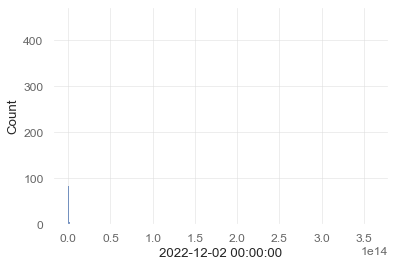

In [23]:
latest_marketcap = marketcap_df.iloc[-1]
latest_marketcap = latest_marketcap[~latest_marketcap.isnull()]

sns.histplot(latest_marketcap)


Vanilla plot is extremely skewed. Why?

- 2022-06-11 기준 시가총액
    1. 삼성전자: 3,808,721억원
    2. LG 에너지솔루션: 994,500억원
    3. SK 하이닉스: 753,482억원
    4. ...

- Solutions:
    - Outlier removal
    - Log transformation


#### Outlier removal

In [24]:
FLOOR_MARKETCAP_QUANTILE = 0.2
CEILING_MARKETCAP_QUANTILE = 0.01


<AxesSubplot:xlabel='2022-12-02 00:00:00', ylabel='Count'>

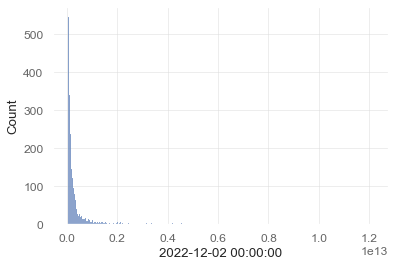

In [25]:
floor_quantile_value = np.quantile(latest_marketcap, FLOOR_MARKETCAP_QUANTILE)
ceiling_quantile_value = np.quantile(latest_marketcap, 1 - CEILING_MARKETCAP_QUANTILE)

latest_marketcap_hist = latest_marketcap[(floor_quantile_value <= latest_marketcap) & (latest_marketcap <= ceiling_quantile_value)]

sns.histplot(latest_marketcap_hist)

#### Log transformation

<AxesSubplot:xlabel='2022-12-02 00:00:00', ylabel='Count'>

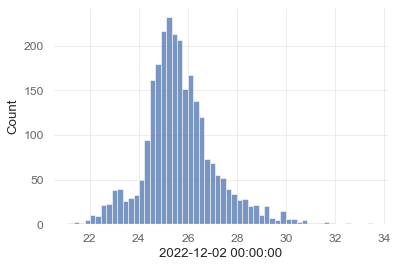

In [26]:
latest_marketcap_log = np.log(latest_marketcap)
sns.histplot(latest_marketcap_log)